# PySpark - GeoPandas Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook to investigate using GeoPandas for spatial data operations and PySpark to (potentially) run them on a compute cluster. This could be useful for processing large datasets of species observations.

Note that installation is slightly tricky due to the mixing of Python with the JVM (Scala/Java) based Spark and the use of latest developments for bridging them (in pyspark, such as Apache Arrow). Transporting spatial data between both environments adds some additional complexity. This notebook is tested with Spark 3.4.0 (currently the latest version).

### Import Packages
Some imports are for future use :-)

Hint: Make sure pyspark package version matches the installed Apache Spark version!

In [16]:
import os.path, json, csv, io

import geopandas.geoseries
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 5)

# for exponential back down when calling APIs
from retrying import retry

# PySpark libraries
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DecimalType
from pyspark.sql import SparkSession

# Spatial pandas libraries
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, shape
from shapely import wkb, wkt

# Used to decode data from Jaba
from ast import literal_eval as make_tuple

### Create a Spark Session

In [17]:
spark = SparkSession.builder.appName("fairicube-geopandas").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=fairicube-geopandas>

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [21]:
species_df = pd.read_csv("../../../local/data/ndff/planten_2016.csv", header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
species_df.drop(columns=['obs_uri'], inplace=True)

# remove the crs prefix from the wkt data
species_df['wkt_excl_crs'] = species_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
species_df.drop(columns=['wkt'], inplace=True)
species_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

species_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Grote ratelaar,Rhinanthus angustifolius,2016,levend exemplaar,100,25,"POLYGON((189374 571738,189373.121320344 571735..."
1,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,3,25,"POLYGON((189221 571670,189220.121320344 571667..."
2,Grote kattenstaart,Lythrum salicaria,2016,levend exemplaar,5,25,"POLYGON((189214 571682,189213.121320344 571679..."
3,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,10,25,"POLYGON((188828 571826,188827.121320344 571823..."
4,Korenbloem,Centaurea cyanus,2016,levend exemplaar,E,102,"POLYGON((264344 484680,264342.242640687 484675..."


In [22]:
# get stats on the numerical data
species_df.describe()

,jaar,straal
count,128967.0,128967.000000
mean,2016.0,94.130677
std,0.0,94.171923
min,2016.0,1.000000
25%,2016.0,25.000000
50%,2016.0,71.000000
75%,2016.0,100.000000
max,2016.0,550.000000


In [23]:
# get stats on the species
species_df['sci_name'].value_counts(sort=True, dropna=True)

sci_name
Rhinanthus angustifolius             6785
Cynosurus cristatus                  6101
Silene flos-cuculi                   6086
Caltha palustris subsp. palustris    4780
Urtica dioica                        4365
                                     ... 
Arnoseris minima                       23
Silene noctiflora                      13
Tilia cordata                          13
Gypsophila muralis                      4
Crepis tectorum                         4
Name: count, Length: 108, dtype: int64

### Create a GeoPandas DataFrame
The observations have spatial attributes, so lift them into a GeoPandas DataFrame to be able to process them.

In [24]:
# construct a GeoDataFrame, with the data using the Dutch RD coordinate reference system
gs = gpd.GeoSeries.from_wkt(species_df['wkt'])
species_gdf = gpd.GeoDataFrame(species_df, geometry=gs, crs="EPSG:28992")

# transform the dataset to the more common WGS84 (unprojected) CRS
species_gdf.to_crs(crs="EPSG:4326", inplace=True)
species_gdf.drop(columns=['wkt'], inplace=True)

species_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Grote ratelaar,Rhinanthus angustifolius,2016,levend exemplaar,100,25,"POLYGON ((5.90077 53.13130, 5.90076 53.13128, ..."
1,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,3,25,"POLYGON ((5.89848 53.13069, 5.89847 53.13068, ..."
2,Grote kattenstaart,Lythrum salicaria,2016,levend exemplaar,5,25,"POLYGON ((5.89838 53.13080, 5.89836 53.13078, ..."
3,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,10,25,"POLYGON ((5.89263 53.13212, 5.89261 53.13210, ..."
4,Korenbloem,Centaurea cyanus,2016,levend exemplaar,E,102,"POLYGON ((6.99171 52.33914, 6.99169 52.33911, ..."


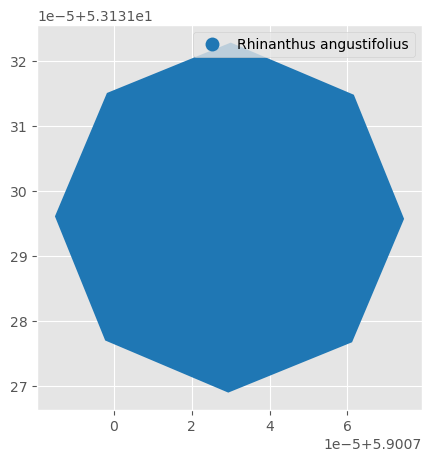

In [25]:
# display a single sample observation
sample_gdf = species_gdf[0:1]
sample_gdf.plot(column='sci_name', categorical=True, legend=True)
plt.show()

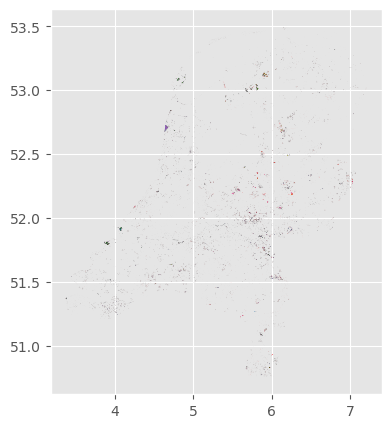

In [26]:
# display all species observations (this might take a while to draw)
species_gdf.plot(column='sci_name', categorical=False, legend=False)
plt.show()

### Create a Spark DataFrame
Here comes the more tricky part to lift the GeoDataFrame into a Spark (distributed) DataFrame.

In [28]:
# take a small sample to experiment with
small_gdf = species_gdf[0:10].copy()
# small_gdf.crs='epsg:4326'

# have to convert the geometry objects (back) to wkt strings for Spark compatibility
small_gdf['wkt'] = pd.Series(
    small_gdf['geometry'].map(lambda x: str(x.wkt), na_action='ignore'),
    index=small_gdf.index, dtype='string'
)

# get rid of the geometry objects that Spark can not automatically interpret
small_gdf.drop(columns=['geometry'], axis=1, inplace=True)

small_gdf

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Grote ratelaar,Rhinanthus angustifolius,2016,levend exemplaar,100,25,POLYGON ((5.9007745408760615 53.13129574217215...
1,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,3,25,"POLYGON ((5.898481512177844 53.13069450533728,..."
2,Grote kattenstaart,Lythrum salicaria,2016,levend exemplaar,5,25,POLYGON ((5.898378205476874 53.130802777598554...
3,Gewone dotterbloem,Caltha palustris subsp. palustris,2016,levend exemplaar,10,25,"POLYGON ((5.892626517801304 53.13212115740124,..."
4,Korenbloem,Centaurea cyanus,2016,levend exemplaar,E,102,"POLYGON ((6.991712202795199 52.33914432876588,..."
5,Korenbloem,Centaurea cyanus,2016,levend exemplaar,E,45,"POLYGON ((6.982705285283902 52.33068153374333,..."
6,Gewone vogelmelk,Ornithogalum umbellatum,2016,levend exemplaar,30,71,POLYGON ((3.4379469230765394 51.38431138326732...
7,Klimop,Hedera helix,2016,levend exemplaar,1,283,"POLYGON ((5.37504587586607 51.664808803499945,..."
8,Knoopkruid,Centaurea jacea,2016,levend exemplaar,5,71,POLYGON ((3.9293650377882186 51.26050070429065...
9,Kruipende boterbloem,Ranunculus repens,2016,levend exemplaar,4,71,POLYGON ((3.9262747465475267 51.26350055655016...


In [29]:
# now create a Spark DataFrame from the GeoPandas DataFrame
spark_df = spark.createDataFrame(data=small_gdf)
spark_df.printSchema()

root
 |-- nl_name: string (nullable = true)
 |-- sci_name: string (nullable = true)
 |-- jaar: long (nullable = true)
 |-- countsubject: string (nullable = true)
 |-- orig_abundance: string (nullable = true)
 |-- straal: long (nullable = true)
 |-- wkt: string (nullable = true)



In [31]:
spark_df.show(10, truncate=True)

+--------------------+--------------------+----+----------------+--------------+------+--------------------+
|             nl_name|            sci_name|jaar|    countsubject|orig_abundance|straal|                 wkt|
+--------------------+--------------------+----+----------------+--------------+------+--------------------+
|      Grote ratelaar|Rhinanthus angust...|2016|levend exemplaar|           100|    25|POLYGON ((5.90077...|
|  Gewone dotterbloem|Caltha palustris ...|2016|levend exemplaar|             3|    25|POLYGON ((5.89848...|
|  Grote kattenstaart|   Lythrum salicaria|2016|levend exemplaar|             5|    25|POLYGON ((5.89837...|
|  Gewone dotterbloem|Caltha palustris ...|2016|levend exemplaar|            10|    25|POLYGON ((5.89262...|
|          Korenbloem|    Centaurea cyanus|2016|levend exemplaar|             E|   102|POLYGON ((6.99171...|
|          Korenbloem|    Centaurea cyanus|2016|levend exemplaar|             E|    45|POLYGON ((6.98270...|
|    Gewone vogelme

In [38]:
# now we can put Spark to work ...
spark_df.select("sci_name", "orig_abundance", 'straal').summary().show()

+-------+--------------------+------------------+-----------------+
|summary|            sci_name|    orig_abundance|           straal|
+-------+--------------------+------------------+-----------------+
|  count|                  10|                10|               10|
|   mean|                null|             19.75|             74.3|
| stddev|                null|33.712015662075146|78.12817104675567|
|    min|Caltha palustris ...|                 1|               25|
|    25%|                null|               3.0|               25|
|    50%|                null|               5.0|               45|
|    75%|                null|              10.0|               71|
|    max|Rhinanthus angust...|                 E|              283|
+-------+--------------------+------------------+-----------------+

